In [2]:
# Base library
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from collections import defaultdict

# Preprocessing
import ppscore as pps
import sklearn
import category_encoders as ce
from sklearn.preprocessing import OneHotEncoder, OrdinalEncoder, RobustScaler,  OneHotEncoder, KBinsDiscretizer
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from custom_preprocessing import *
from SegmentPerformance import *

# Resampling
from imblearn.over_sampling import SMOTE
from imblearn.under_sampling import TomekLinks
from imblearn.pipeline import Pipeline as ImbPipeline

# Modeling
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier, GradientBoostingClassifier
from xgboost import XGBClassifier
from xgboost import plot_tree
from sklearn.model_selection import (train_test_split, cross_val_score, cross_val_predict, StratifiedKFold, GridSearchCV,
                                    learning_curve, ShuffleSplit)

# Evaluation
from sklearn.metrics import (accuracy_score, recall_score, precision_score, f1_score, confusion_matrix, classification_report,ConfusionMatrixDisplay, brier_score_loss)
from sklearn.calibration import calibration_curve
import dice_ml
from dice_ml import Data, Model, Dice
import random
import shap

# Deployment
import pickle
import warnings
warnings.filterwarnings('ignore')

---
---

# **4. Data Cleaning**

---
---

In [3]:
# Read dataset
dfraw = pd.read_csv("bank-additional-full.csv", sep=';')

# Rename target column
dfraw = dfraw.rename(columns={'y': 'Deposit'})

# Replace 'Yes' with 1 and 'No' with 0
dfraw['Deposit'] = dfraw['Deposit'].replace({'yes': 1, 'no': 0})
dfraw.head()

,age,job,marital,education,default,housing,loan,contact,month,day_of_week,...,campaign,pdays,previous,poutcome,emp.var.rate,cons.price.idx,cons.conf.idx,euribor3m,nr.employed,Deposit
0,56,housemaid,married,basic.4y,no,no,no,telephone,may,mon,...,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,0
1,57,services,married,high.school,unknown,no,no,telephone,may,mon,...,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,0
2,37,services,married,high.school,no,yes,no,telephone,may,mon,...,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,0
3,40,admin.,married,basic.6y,no,no,no,telephone,may,mon,...,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,0
4,56,services,married,high.school,no,no,yes,telephone,may,mon,...,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,0


In [4]:
# Check duplicates

dfraw.duplicated().sum()

12

In [5]:
# Drop Duplicates
dfraw.drop_duplicates(inplace=True)
dfraw.shape

(41176, 21)

In [6]:
# Split the data
df_seen, df_unseen = train_test_split(dfraw, test_size=0.2, random_state=42, stratify=dfraw['Deposit'])
df_seen.shape, df_unseen.shape

((32940, 21), (8236, 21))

#### **4.1. Check Missing Values**  

As we know, this dataset has no null values since the beginning. But, we have a specific column that indicates likely-null values `Prev_DaysPassed`.   

This feature represents the number of days since the last contact with the client, with 999 indicating no previous contact. The values are integers, and 999 is a special value indicating a missing or non-applicable situation. The value 999 should be treated as a special case. You might want to replace 999 with a missing value indicator (NaN) and then handle it accordingly.

In [7]:
df_seen['pdays'].value_counts(normalize=True)

999    0.963358
3      0.010504
6      0.009806
4      0.002793
2      0.001579
9      0.001488
7      0.001427
10     0.001366
12     0.001336
5      0.001063
13     0.001002
11     0.000698
15     0.000668
1      0.000607
14     0.000516
8      0.000425
0      0.000395
16     0.000273
17     0.000243
18     0.000182
22     0.000091
26     0.000030
21     0.000030
27     0.000030
19     0.000030
20     0.000030
25     0.000030
Name: pdays, dtype: float64

However, as we can see from the value counts below, the proportion of 999 is 96% which is 96% of NaN. This huge number may be reasonable to drop this feature.

**Missing Attribute Values:** There are several missing values in some categorical attributes, all coded with the "unknown" label. These missing values can be treated as a possible class label or using deletion or imputation techniques. But, in this case, we assume that "unknown" value is a possible class label where the customer didn't fill in the category.

#### **4.2. Check Invalid Values**  

**Age Feature**

Based on the EDA: Reference of minimum age for opening account is 18 years old and life expectancy in Portugal is 83.

In [8]:
df_seen[(df_seen['age'] < 18) | (df_seen['age'] > 83)].shape

(59, 21)

There are 59 customer data that do not meet the age criteria. Therefore, we will filter data that does not match the criteria and only do modeling for customers with an age range of 18-83 years.

In [9]:
df_seen[(df_seen['age'] >= 18) & (df_seen['age'] <= 83)].shape

(32881, 21)

If we exclude the customers that do not meet the age criteria, then it will be 32881 data.

In [10]:
df_seen = df_seen[(df_seen['age'] >= 18) & (df_seen['age'] <= 83)]
df_seen.shape

(32881, 21)

**Prev_QtyContact & Prev_Outcome**

In EDA, we found that there are inconsistent data where `pdays` is 999 (didn't contact) but the `previous` isn't 0 and `poutcome` isn't Nonexistent.

In [11]:
df_seen[(df_seen['previous']==0) & (df_seen['poutcome']!="nonexistent")]

,age,job,marital,education,default,housing,loan,contact,month,day_of_week,...,campaign,pdays,previous,poutcome,emp.var.rate,cons.price.idx,cons.conf.idx,euribor3m,nr.employed,Deposit


From the result above, we know that from previous campaign information, there's no inconsistent data where of contacts performed before this campaign  is 0 and previous outcome isn't 'nonexistent'.

#### **4.3. Check Outliers**  

From EDA, we know some features have outliers. But, after cleaning, we should re-check the outliers.

In [12]:
# Define Function to Calculate IQR and Outliers
def IQR_outlier(data, col):
    Q1 = data[col].quantile(1/4)
    Q3 = data[col].quantile(3/4)
    IQR = Q3 - Q1
    outlier_lower = Q1 - 1.5 * IQR
    outlier_upper = Q3 + 1.5 * IQR
    total_outliers = len(data[(data[col] < outlier_lower) | (data[col] > outlier_upper)])
    outlier_percentage = round(total_outliers / len(data[col]) * 100, 2)
    return outlier_lower, outlier_upper, total_outliers, outlier_percentage

# Define an Empty List to Store Function Result
numerical_cols = df_seen.select_dtypes(include=['int64', 'float64']).columns.to_list()
outlier = []
for col in numerical_cols:
    lower_band, upper_band, total_outliers, outlier_percentage = IQR_outlier(df_seen, col)
    outlier.append([col, lower_band, upper_band, total_outliers, outlier_percentage])

# Turn the Outliers List Into a Dataframe
outlier_info_df = pd.DataFrame(outlier, columns=["Columns", "Lower Band", "Upper Band", "Total Outliers", "Percentage of Outliers (%)"])
outlier_info_df

,Columns,Lower Band,Upper Band,Total Outliers,Percentage of Outliers (%)
0,age,9.5000,69.5000,329,1.00
1,duration,-223.5000,644.5000,2342,7.12
2,campaign,-2.0000,6.0000,1909,5.81
3,pdays,999.0000,999.0000,1192,3.63
4,previous,0.0000,0.0000,4484,13.64
5,emp.var.rate,-6.6000,6.2000,0,0.00
6,cons.price.idx,91.6965,95.3725,0,0.00
7,cons.conf.idx,-52.1500,-26.9500,351,1.07
8,euribor3m,-4.0815,10.3865,0,0.00
9,nr.employed,4905.6000,5421.6000,0,0.00


We can see the statistical summary for numerical features seems better than before cleaning (EDA).

* For `ConsConf_idx` we'll check if there's redundant feature since it contains socio-economic information along with other socio-economic features.  

* For `Age` and `LastContact_Duration(s)`, we'll perform binning to "grouping" and handle their outliers.  
This outlier handling investigates how equal frequency discretization (also known as 'quantile discretization') works on outliers in the dataset. Theoretically speaking, this technique converts numerical data into intervals (bins) based on quentiles.  

* For `Qty_Contact` and `Prev_QtyContact` we'll let the outliers since the data is categorical numeric value and we'll use Robust Scaling. Robust scaling is a data preprocessing technique used to normalize data, especially in cases where the data contains outliers. Unlike standard scaling methods such as z-score normalization (which uses the mean and standard deviation), robust scaling uses statistics that are less sensitive to outliers: the median and the interquartile range (IQR). This makes robust scaling particularly effective for datasets with outliers or skewed distributions.<br>   
 Each feature value is transformed by subtracting the median and then dividing by the IQR $$X_{\text{scaled}}=\frac{X-\text{median}(X)}{IQR(X)}$$
    <br>


#### **4.4. Checking Cardinality**

Checking cardinality is a fundamental step before building a classification model. This process helps to understand how a categorical variable is distributed within the dataset, particularly regarding its variability. It's important because a high number of unique values in a column can create challenges for classification models. Additionally, this assessment will guide us in choosing the most appropriate encoding technique for our dataset.

In [13]:
pd.DataFrame({
    'ColumnName': dfraw.columns.values.tolist(),
    'Nrow': dfraw.shape[0],
    'UniqueValue': dfraw.nunique().tolist(),
})

,ColumnName,Nrow,UniqueValue
0,age,41176,78
1,job,41176,12
2,marital,41176,4
3,education,41176,8
4,default,41176,3
5,housing,41176,3
6,loan,41176,3
7,contact,41176,2
8,month,41176,10
9,day_of_week,41176,5


Regrouping for `Job` and `Education`

* Job:
    * The categories 'Self-employed' and 'Entrepreneur' will be merged into Self-Employed.
    * 'Housemaid' will be included in the 'Services' category.
    * 'Student', 'Retired', 'Unemployed', and 'Unknown' will all be grouped under 'Unemployed'.
* Education:
    * Based on this [article](https://en.wikipedia.org/wiki/Education_in_Portugal#Secondary_education), all the category is valid and unique, for next process we will group category Basic.9y, Basic.4y, and Basic.6y as Basic Education**.
    * 'Unknown' and 'Illiterate' will be grouped as "Others".

#### **4.5. Label Ambiguity Checking**  

Label ambiguity means where the data point cannot be annotated as one of the given labels (occurred 2, with 0 and 1 label). 50% of subscribe and 50% of not subscribe might be confusing the model to predict.  
Example :  
Feature combination A : [0,0,1,1,0] => 0  
Feature combination B : [1,1,1,1,0] => 1  
Feature combination C : [0,1] => ?   

We'll try to see how the pattern for each features combination and check the label ambiguity to help model generalize the pattern easier.

In [14]:
def aggregate_labels_indices(group):
    return pd.Series({
        'Instances': len(group),
        'Deposit': list(group['Deposit']),
        'Indices': list(group.index)
    })

In [15]:
# Group by features and aggregate
ambiguous_label = df_seen.groupby(['age', 'job', 'marital', 'education', 'default', 'housing', 'loan',
       'contact', 'month', 'day_of_week', 'duration', 'campaign', 'pdays',
       'previous', 'poutcome', 'emp.var.rate', 'cons.price.idx',
       'cons.conf.idx', 'euribor3m', 'nr.employed']).apply(aggregate_labels_indices)

# Filter groups with different labels
ambiguous_label = ambiguous_label[ambiguous_label['Deposit'].apply(lambda x: len(set(x)) > 1)]

ambiguous_label.reset_index(inplace=True)
ambiguous_label.head()

,age,job,marital,education,default,housing,loan,contact,month,day_of_week,...,previous,poutcome,emp.var.rate,cons.price.idx,cons.conf.idx,euribor3m,nr.employed,Instances,Deposit,Indices


There's no ambiguous label that may confuse the model.

#### **4.6. Pipelining**

Creating the pipeline for data cleaning process.

In [16]:
groups = {
    # Job dict
    'admin.': 'admin',
    'entrepreneur': 'self-employed',
    'housemaid': 'services',
    'student': 'unemployed',
    'retired': 'unemployed',
    'unknown': 'unemployed',

    # Education dict
    'basic.9y': 'basic',
    'basic.4y': 'basic',
    'basic.6y': 'basic',
    'high.school': 'high school',
    'unknown': 'others',
    'illiterate':'others',
    'university.degree': 'university',
    'professional.course': 'professional'
}

In [17]:
# Define ColumnTransformer
cleaner = ColumnTransformer(
    transformers=[
        ('regrouping', ValueConverter(mapping_dict=groups), ['Education', 'Job']), 
        ('binning', KBinsDiscretizer(encode='ordinal', strategy='quantile'), ['LastContact_Duration(s)', 'Age'])
    ],
    remainder='passthrough',
    verbose_feature_names_out=False
).set_output(transform='pandas')

cleaner

ColumnTransformer(remainder='passthrough',
                  transformers=[('regrouping',
                                 ValueConverter(mapping_dict={'admin.': 'admin',
                                                              'basic.4y': 'basic',
                                                              'basic.6y': 'basic',
                                                              'basic.9y': 'basic',
                                                              'entrepreneur': 'self-employed',
                                                              'high.school': 'high '
                                                                             'school',
                                                              'housemaid': 'services',
                                                              'illiterate': 'others',
                                                              'professional.course': 'professional',
                                                              'retired': 'unemployed',
                                                              'student': 'unemployed',
                                                              'university.degree': 'university',
                                                              'unknown': 'others'}),
                                 ['Education', 'Job']),
                                ('binning', KBinsDiscretizer(encode='ordinal'),
                                 ['LastContact_Duration(s)', 'Age'])],
                  verbose_feature_names_out=False)

In data cleaning pipeline, we grouped `Education` and `Job` for reducing the unique value but also reasonable. We also do binning for `LastContact_Duration` and `Age` to handle their outliers.

---
---

# **5. Feature Engineering**

---
---

<h2><b>5.1. Feature Extraction

In [18]:
feature_extraction = ColumnTransformer(
    transformers=[
        ('loan_status', ValueClassifier(
            conditions=[
                'Housing_Loan == "no" and Personal_Loan == "no"',
                'Housing_Loan == "yes" and Personal_Loan == "no"',
                'Housing_Loan == "no" and Personal_Loan == "yes"',
                'Housing_Loan == "yes" and Personal_Loan == "yes"'
            ],
            choices=['No Loan', 'Housing', 'Personal', 'Housing and Personal'],
            rename='Loan_Status'
            ),
            ['Housing_Loan', 'Personal_Loan']),
    ],
    remainder='passthrough',
    verbose_feature_names_out=False
).set_output(transform='pandas')

feature_extraction

ColumnTransformer(remainder='passthrough',
                  transformers=[('loan_status',
                                 ValueClassifier(choices=['No Loan', 'Housing',
                                                          'Personal',
                                                          'Housing and '
                                                          'Personal'],
                                                 conditions=['Housing_Loan == '
                                                             '"no" and '
                                                             'Personal_Loan == '
                                                             '"no"',
                                                             'Housing_Loan == '
                                                             '"yes" and '
                                                             'Personal_Loan == '
                                                             '"no"',
                                                             'Housing_Loan == '
                                                             '"no" and '
                                                             'Personal_Loan == '
                                                             '"yes"',
                                                             'Housing_Loan == '
                                                             '"yes" and '
                                                             'Personal_Loan == '
                                                             '"yes"'],
                                                 rename='Loan_Status'),
                                 ['Housing_Loan', 'Personal_Loan'])],
                  verbose_feature_names_out=False)

We created new feature from loan information put it into pipeline where it will create new category `Loan_Status` with detail information; No loans, Housing or Personal loan only, Both loans.

## **5.2. Feature Selection**

**Power Predictive Score** (PPS) is a metric used to measure the predictive power of a feature with respect to the target variable in a dataset. It helps in evaluating how well a feature can predict the target variable. By evaluating PPS, we can select features that have higher predictive power, thus improving the performance and interpretability of our model.

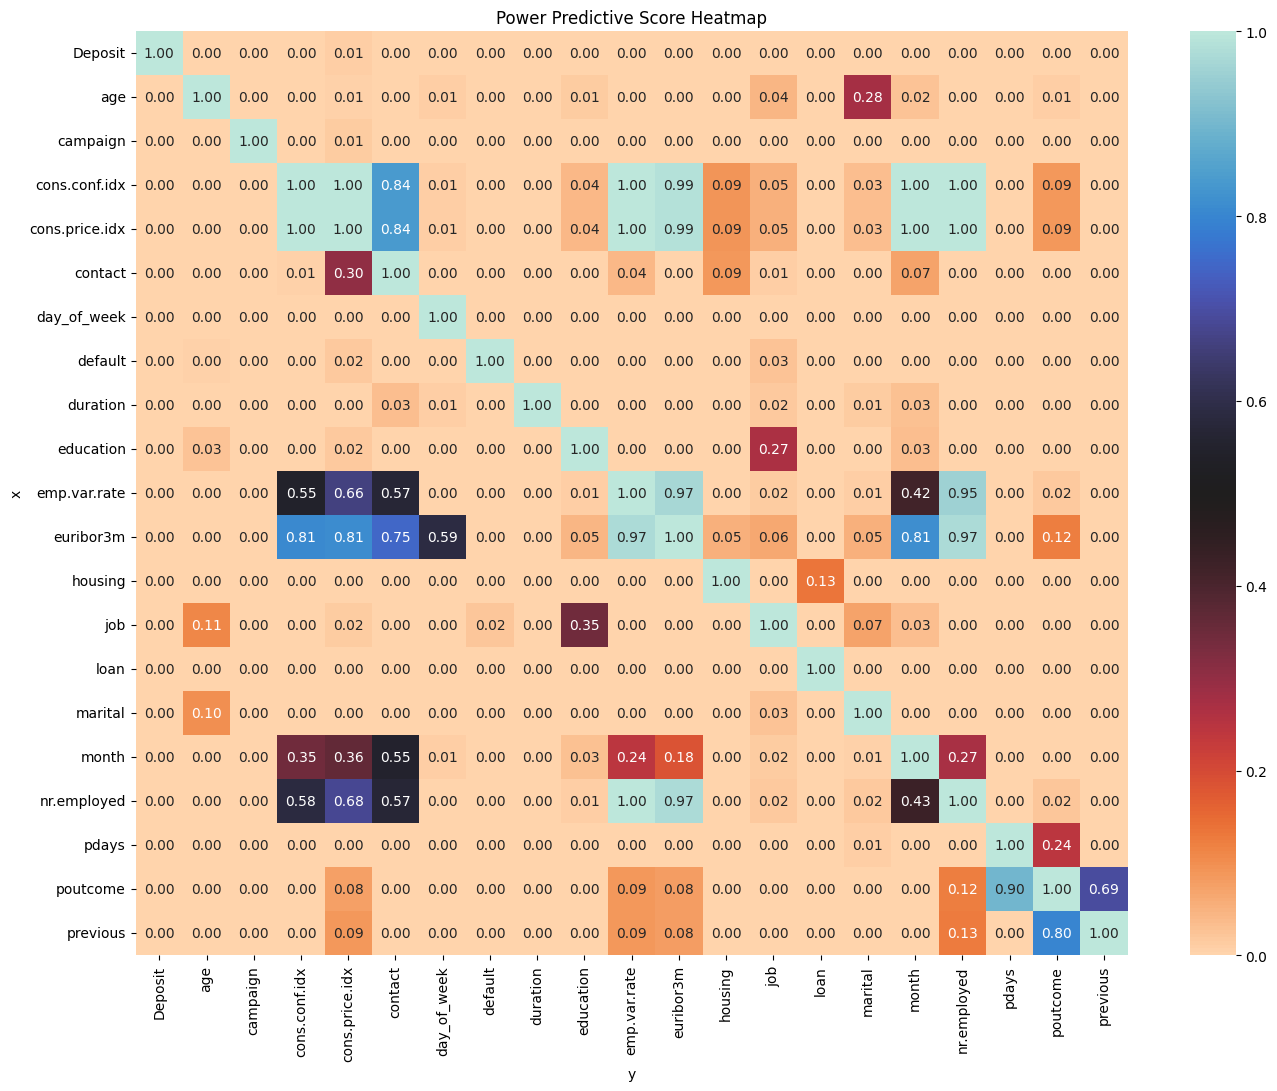

In [19]:
# Calculate the PPS matrix
pps_matrix = pps.matrix(df_seen)

# Pivot the PPS matrix to a format suitable for heatmap
pps_pivot = pps_matrix.pivot(index='x', columns='y', values='ppscore')

# Show
plt.figure(figsize=(16,12))
sns.heatmap(pps_pivot, annot=True, fmt=".2f", cmap='icefire_r')
plt.title('Power Predictive Score Heatmap')
plt.show()

Summary :  
Even if features are highly correlated, if their PPS scores with the target variable are low, it implies that while the features are related to each other, they might not be useful in predicting the target variable, and it suggests redundancy. Including redundant features can lead to overfitting and may not improve model performance.  

Handling :  
So, we will remove features that are highly correlated with others or redundant, `Prev_DaysPassed` since it contains 96% of NaN, `Credit_Default` since the Yes value is just 3 that doesn't give valuable information, and `Housing_Loan` and `Personal_Loan` after extracted into new feature.

In [20]:
# Drop Redundant Features
selector = ColumnTransformer(
    transformers=[
        ('feature_select', 'drop', ['ConsConf_Idx','ConsPrice_Idx','Euribor3M_Rate', 'EmpVar_Rate', 'Prev_DaysPassed',
                                    'Housing_Loan', 'Personal_Loan', 'Credit_Default']),
    ],
    remainder='passthrough', verbose_feature_names_out=False).set_output(transform='pandas')

selector

ColumnTransformer(remainder='passthrough',
                  transformers=[('feature_select', 'drop',
                                 ['ConsConf_Idx', 'ConsPrice_Idx',
                                  'Euribor3M_Rate', 'EmpVar_Rate',
                                  'Prev_DaysPassed', 'Housing_Loan',
                                  'Personal_Loan', 'Credit_Default'])],
                  verbose_feature_names_out=False)

## **5.3. Feature Encoding**  

* Custom Encoding for `Prev_Outcome`.
* One Hot Encoding for categorical features that has less than 5 unique values. `Marital`, `Contact_Type`, and `Loan_Status` b
* Binary Encoding for categorical features that has more than 5 unique values. `Job`, `LastContact_Month	`, `LastContact_Day`
* Label Encoding for `Education`.

In [21]:
# Mapping
mappings = {
    'nonexistent': 1, 'failure': 2, 'success': 3,                                                                                 
}

# Pipelining
preprocessor = ColumnTransformer(
    transformers=[
        ('custom_encode', ValueConverter(mapping_dict=mappings, default_value=0), ['Prev_Outcome']),
        ('ohe_encode', OneHotEncoder(drop='first'), ['Marital', 'Contact_Type', 'Loan_Status']),
        ('binary_encode', ce.BinaryEncoder(), ['Job', 'LastContact_Month', 'LastContact_Day']),
        ('label_encode', OrdinalEncoder(), ['Education']),
        ('scaler', RobustScaler(), ['Prev_QtyContact', 'Qty_Contact'])
    ],
    remainder='passthrough', verbose_feature_names_out=False)

preprocessor

ColumnTransformer(remainder='passthrough',
                  transformers=[('custom_encode',
                                 ValueConverter(default_value=0,
                                                mapping_dict={'failure': 2,
                                                              'nonexistent': 1,
                                                              'success': 3}),
                                 ['Prev_Outcome']),
                                ('ohe_encode', OneHotEncoder(drop='first'),
                                 ['Marital', 'Contact_Type', 'Loan_Status']),
                                ('binary_encode', BinaryEncoder(),
                                 ['Job', 'LastContact_Month',
                                  'LastContact_Day']),
                                ('label_encode', OrdinalEncoder(),
                                 ['Education']),
                                ('scaler', RobustScaler(),
                                 ['Prev_QtyContact', 'Qty_Contact'])],
                  verbose_feature_names_out=False)

<h2><b>5.4. Pipelining

In this section we'll create overall pipeline to ensure the data test will be preprocessed correctly and minimum data leakage. We've done many combinations to get the best score, but in this notebook we just show the best experiment of preprocessing data.

In [22]:
# Renaming the features for better comprehension
rename_dict = {'age':'Age',
               'job':'Job',
               'marital':'Marital',
               'education':'Education',
               'default':'Credit_Default',
               'housing':'Housing_Loan',
               'loan':'Personal_Loan',
               'contact':'Contact_Type',
               'day_of_week':'LastContact_Day',
               'month':'LastContact_Month',
               'duration':'LastContact_Duration(s)',
               'campaign':'Qty_Contact',
               'pdays':'Prev_DaysPassed',
               'previous':'Prev_QtyContact',
               'poutcome':'Prev_Outcome',
               'emp.var.rate':'EmpVar_Rate',
               'cons.price.idx':'ConsPrice_Idx',
               'cons.conf.idx':'ConsConf_Idx',
               'euribor3m':'Euribor3M_Rate',
               'nr.employed':'Qty_Employee',
}

# Define the preprocessing pipeline
base_pipeline = Pipeline(steps=[
    ('rename', ColumnRenamer(rename_dict=rename_dict)),
    ('data_cleaning', cleaner),
    ('feature_extraction', feature_extraction),
    ('feature selection', selector),
    ('feature transformation', preprocessor)
])

# Show
base_pipeline

Pipeline(steps=[('rename',
                 ColumnRenamer(rename_dict={'age': 'Age',
                                            'campaign': 'Qty_Contact',
                                            'cons.conf.idx': 'ConsConf_Idx',
                                            'cons.price.idx': 'ConsPrice_Idx',
                                            'contact': 'Contact_Type',
                                            'day_of_week': 'LastContact_Day',
                                            'default': 'Credit_Default',
                                            'duration': 'LastContact_Duration(s)',
                                            'education': 'Education',
                                            'emp.var.rate': 'EmpVar_Rate',
                                            'euribor3m': 'Euribor3M...
                                                                               'nonexistent': 1,
                                                                               'success': 3}),
                                                  ['Prev_Outcome']),
                                                 ('ohe_encode',
                                                  OneHotEncoder(drop='first'),
                                                  ['Marital', 'Contact_Type',
                                                   'Loan_Status']),
                                                 ('binary_encode',
                                                  BinaryEncoder(),
                                                  ['Job', 'LastContact_Month',
                                                   'LastContact_Day']),
                                                 ('label_encode',
                                                  OrdinalEncoder(),
                                                  ['Education']),
                                                 ('scaler', RobustScaler(),
                                                  ['Prev_QtyContact',
                                                   'Qty_Contact'])],
                                   verbose_feature_names_out=False))])

**Pipeline Initialization**  
The pipeline is defined to standardize our workflow, ensuring consistent preprocessing and model training. Each step in this pipeline is carefully selected based on extensive experimentation.

1. Rename Columns  
    We start by renaming columns to standardize names for better comprehension, ensuring consistency throughout the process. This step is crucial to avoid any confusion or errors when referencing column names in later steps.

2. Data Cleaning  
    Here we apply various data cleaning techniques like regrouping and handle outliers using binning. Clean data is essential for ensuring the quality and accuracy of the subsequent model predictions.

3. Feature Extraction  
    We worked with complex data, so it's necessary to find some patterns that can help model to generalize the pattern to give the best performance.

4. Feature Selection  
    In this step, we select the most relevant features that contribute significantly to the target variable. By removing irrelevant or redundant features, we aim to improve model performance and only selected the best features.  

5. Feature Transformation  
    We transform the selected features to better fit the machine learning model's requirements. Transformations include scaling and encoding categorical variables.

**Summary**  
This pipeline represents the culmination of our experiments and is designed to deliver robust and accurate predictions. By using this well-defined process, we can confidently compare different models and select the best performing one for our specific problem. The entire pipeline is built to be flexible and modular, allowing for easy adjustments and tuning in future iterations and ensure the unseen data will be processed correctly.

---
---

# **6. Modeling Experiments**

---
---

In [23]:
# Split X and y in data train
X_train = df_seen.drop(columns='Deposit')
y_train = df_seen.Deposit

# Split X and y in data test
X_test = df_unseen.drop(columns='Deposit')
y_test = df_unseen.Deposit

<h2><b>6.0. Model-Business Explanation

In [24]:
# Historical data - Without Modeling

total_customers = len(dfraw)
total_deposit_subscriptions = len(dfraw[dfraw['Deposit'] == 1])
total_non_subscriptions = len(dfraw[dfraw['Deposit'] == 0])
deposit = 500
tele_cost = 23

# Conversion rate and Revenue
conversion_rate = total_deposit_subscriptions / total_customers * 100
possible_revenue = total_customers * deposit

# ROAS (Revenue On Ad Spend)
total_revenue = total_deposit_subscriptions * deposit
total_tele_cost = total_customers * tele_cost
romi = (total_revenue-total_tele_cost)/total_tele_cost * 100

print("Historical Total Customers is: ", total_customers)
print("Historical Total Deposit Subscriptions is: ", total_deposit_subscriptions)
print("Historical Conversion Rate is: ", round(conversion_rate, 2), "(%)")
print("Historical Total Revenue is: EUR ", round(total_revenue, 2))
print("Historical Total Possible Revenue If All Subscribed: EUR", round(possible_revenue, 2))
print("Historical Total Telemarketing Cost: EUR", round(total_tele_cost, 2))
print("Historical ROMI (Return On Marketing Investment): ", round(romi, 2), "(%)")

Historical Total Customers is:  41176
Historical Total Deposit Subscriptions is:  4639
Historical Conversion Rate is:  11.27 (%)
Historical Total Revenue is: EUR  2319500
Historical Total Possible Revenue If All Subscribed: EUR 20588000
Historical Total Telemarketing Cost: EUR 947048
Historical ROMI (Return On Marketing Investment):  144.92 (%)


In [25]:
# Prediction Data

total_unseen_customers = len(df_unseen)
total_unseen_deposit_subscriptions = len(df_unseen[df_unseen['Deposit'] == 1])
total_unseen_non_subscriptions = len(df_unseen[df_unseen['Deposit'] == 0])
deposit = 500
tele_cost = 23

# Conversion rate and Revenue
cvr_unseen = total_unseen_deposit_subscriptions / total_unseen_customers * 100
possible_revenue_unseen = total_unseen_customers * deposit
total_unseen_revenue = total_unseen_deposit_subscriptions * deposit

print("Unseen - Total Customers is: ", total_unseen_customers)
print("Unseen - Conversion Rate is: ", round(cvr_unseen, 2), "(%)")
print("Unseen - Total Revenue is: EUR ", round(total_unseen_revenue, 2))

Unseen - Total Customers is:  8236
Unseen - Conversion Rate is:  11.27 (%)
Unseen - Total Revenue is: EUR  464000


We've calculated the data from historical and unseen sources. Since we split the data with the same proportion of deposit subscription status, the Conversion Rate is still the same. But, since we want to do marketing campaign only for customer who likely to subscribe, so we can't directly calculate using df_unseen. Thus, we will calculate through our model.

We will do modeling to see which model can give us the highest Conversion Rate and ROMI (Return On Marketing Investment) aligned with the best Precision score.

## **6.1. Benchmark Model**

**Setup of Modeling and Business Metrics**


Here's we will create functions to directly calculate the CVR (Conversion Rate) and ROMI (Return On Marketing Investment) through our model.  

1. **Funtion calc_cvr**   
  *Purpose* : Measures the effectiveness of a marketing campaign by calculating the percentage of successful outcomes (True Positives, TP) among all the predicted positive outcomes (TP + FP).  

    *Business Relevance*: A higher CVR indicates that the marketing efforts are successful in reaching clients who are likely to respond positively.

2. **Function calc_romi**  
  *Purpose* : Evaluates the financial return on investment from a marketing campaign by comparing the revenue generated against the costs incurred.

    *Business Relevance* : ROMI helps assess whether the marketing campaign is profitable. We calculate based on positive class since we only targeting the customers who likely to subscribe.

3. **Scoring**   
  *Purpose* : To evaluate the performance of machine learning models using specific metrics relevant to business objectives.  
  We choose **Precision** since the metric align with our business purpose and in this case is as same as Conversion Rate. Precision measures the proportion of true positives among all predicted positives. High precision means fewer false positives.



**Calculate CVR**

In [26]:
def calc_cvr(y_true, y_pred):
    # Confusion Matrix Components
    TP = sum((y_true == 1) & (y_pred == 1))
    FP = sum((y_true == 0) & (y_pred == 1))
    CVR = (TP / (TP + FP)) * 100
    return CVR

**Calculate ROMI**

In [27]:
def calc_romi(y_true, y_pred):
    # Confusion Matrix Components
    TP = sum((y_true == 1) & (y_pred == 1))
    FP = sum((y_true == 0) & (y_pred == 1))

    total_revenue = TP * 500
    total_cost = (TP + FP) * 23

    romi = (total_revenue - total_cost) / total_cost * 100
    return romi

**Configuration of Algorithm Type**

The dictionary list_models is designed to store different machine learning algorithms that can be used to perform binary classification tasks. Each key in the dictionary represents the name of a model, and the corresponding value is an instance of that model with specific configurations.

In [28]:
# List of models for binary classification
list_models = [
    ('KNN', KNeighborsClassifier()),
    ('Logistic Regression', LogisticRegression(random_state=42)),
    ('Decision Tree', DecisionTreeClassifier(random_state=42)),
    ('Random Forest', RandomForestClassifier(random_state=42)),
    ('XGBoost', XGBClassifier(random_state=42)),
    ('Naive Bayes', GaussianNB()),
    ('AdaBoost', AdaBoostClassifier(random_state=42)),
    ('Gradient Boosting', GradientBoostingClassifier(random_state=42))
]

**Others**

Here, we includes stratified k-fold to ensure each fold of the training set maintains the same proportion of the target class label. This is done as the distribution of deposit and non-deposit customers in the target variable is imbalanced. This technique attempts to mitigate bias in certain fold if the classes are not stratified.

In [29]:
# Use stratified k-fold cross-validation
stratified_cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

This function constructs and returns a dictionary of machine learning models, each encapsulated in a pipeline. The pipeline includes preprocessing steps (defined in baseline), optional data balancing steps (if provided), and a classifier. 

In [30]:
def evaluate_models(models, X_train, X_test, y_train, y_test, experiment_pipeline=None):
    results = defaultdict(list)

    for model_name, model in models:
        # Combine preprocessing pipeline with the experiment pipeline (if provided)
        if experiment_pipeline:
            # Extract steps from base_pipeline end experiment pipeline
            base_steps = base_pipeline.steps
            experiment_steps = experiment_pipeline.steps

            # Combine all steps
            all_steps = base_steps + experiment_steps + [('classifier', model)]
            full_pipeline = ImbPipeline(steps=all_steps)
        else:
            full_pipeline = Pipeline(steps=[
                ('preprocessing', base_pipeline),
                ('classifier', model)
            ])

        # Fit and predict
        full_pipeline.fit(X_train, y_train)
        y_pred_train = full_pipeline.predict(X_train)
        y_pred_test = full_pipeline.predict(X_test)

        # Calculate metrics
        accuracy = accuracy_score(y_test, y_pred_test)
        precision_train = precision_score(y_train, y_pred_train)
        precision_test = precision_score(y_test, y_pred_test)
        precision_diff = abs(precision_train - precision_test)
        recall = recall_score(y_test, y_pred_test)
        f1score = f1_score(y_test, y_pred_test)
        cvr = calc_cvr(y_test, y_pred_test)
        romi = calc_romi(y_test, y_pred_test)

        y_pred_train_cv = cross_val_predict(full_pipeline, X_train, y_train, cv=stratified_cv)
        precision_train_cv = precision_score(y_train, y_pred_train_cv)

        results['Model'].append(model_name)
        results['Accuracy'].append(accuracy)
        results['Precision Train'].append(precision_train)
        results['Precision Test'].append(precision_test)
        results['Precision Difference'].append(precision_diff)
        results['Recall'].append(recall)
        results['F1 Score'].append(f1score)
        results['CVR'].append(cvr)
        results['ROMI'].append(romi)

    results_df = pd.DataFrame(results)
    results_df = results_df.sort_values(by='Precision Difference')

    # Highlighting the highest values
    result_df = results_df.style.highlight_max(subset=['Accuracy', 'Precision Train', 'Precision Test', 'Recall', 'F1 Score', 'CVR', 'ROMI'], color='lightgreen')\
                               .highlight_min(subset=['Precision Difference'], color='lightgreen')

    return result_df

### **6.1.1. Experiment 0: Baseline Models**

In [31]:
# Display the Result
print("Model Performance for Baseline Models")
base_results = evaluate_models(list_models, X_train, X_test, y_train, y_test, experiment_pipeline=None)
base_results

Model Performance for Baseline Models


### **6.1.2. Experiment 1: SMOTE**

**Purpose**: SMOTE is used to oversample the minority class by generating synthetic examples rather than by duplicating existing examples. This helps in balancing the class distribution and preventing the model from being biased towards the majority class.

**How It Works**: SMOTE works by creating synthetic samples from the minority class that are similar to existing samples, thereby increasing the representation of the minority class.

In [31]:
exp1 = ImbPipeline(steps=[
    ('smote', SMOTE(sampling_strategy='minority', random_state=42)),
])

results_exp1 = evaluate_models(list_models, X_train, X_test, y_train, y_test, experiment_pipeline=exp1)
results_exp1

,Model,Accuracy,Precision Train,Precision Test,Precision Difference,Recall,F1 Score,CVR,ROMI
6,AdaBoost,0.869961,0.445599,0.450382,0.004783,0.699353,0.547911,45.038168,879.090607
1,Logistic Regression,0.777562,0.319536,0.313531,0.006005,0.818966,0.453461,31.353135,581.589898
5,Naive Bayes,0.825522,0.337141,0.345100,0.007959,0.610991,0.441074,34.510043,650.218317
7,Gradient Boosting,0.874089,0.468739,0.460707,0.008032,0.688578,0.552052,46.070656,901.536002
0,KNN,0.828558,0.483739,0.376531,0.107208,0.795259,0.511080,37.653061,718.544809
4,XGBoost,0.905537,0.785714,0.616460,0.169255,0.427802,0.505089,61.645963,1240.129625
3,Random Forest,0.897887,0.973836,0.555841,0.417996,0.466595,0.507323,55.584082,1108.349612
2,Decision Tree,0.876639,0.993687,0.453291,0.540396,0.460129,0.456684,45.329087,885.414936


<h3><b>6.1.3. Experiment 2: TomekLinks  


**Purpose**: Tomek links are used to undersample the majority class by identifying pairs of instances (one from each class) that are closest to each other. By removing the majority class instance of each pair, Tomek links aim to increase the margin between classes.

**How It Works**: Tomek links algorithmically identifies pairs of instances—one from the majority class and one from the minority class—that are closest to each other. It then removes the majority class instance of each pair, which helps in cleaning up the overlap and improving the separation between classes.

In [32]:
exp2 = ImbPipeline(steps=[
    ('tomek', TomekLinks(sampling_strategy = 'majority')),
])

results_exp2 = evaluate_models(list_models, X_train, X_test, y_train, y_test, experiment_pipeline=exp2)
results_exp2

,Model,Accuracy,Precision Train,Precision Test,Precision Difference,Recall,F1 Score,CVR,ROMI
5,Naive Bayes,0.851263,0.376319,0.377374,0.001055,0.492457,0.427302,37.737407,720.378415
7,Gradient Boosting,0.911608,0.656753,0.654799,0.001955,0.455819,0.537484,65.479876,1323.475569
1,Logistic Regression,0.896916,0.620478,0.600509,0.019969,0.254310,0.357305,60.050891,1205.454143
6,AdaBoost,0.900559,0.613391,0.587480,0.025911,0.394397,0.471954,58.747994,1177.130295
0,KNN,0.898616,0.698358,0.564673,0.133685,0.437500,0.493018,56.467316,1127.550342
4,XGBoost,0.907601,0.781693,0.614856,0.166837,0.481681,0.540181,61.485557,1236.642545
3,Random Forest,0.903594,0.893503,0.588859,0.304644,0.478448,0.527943,58.885942,1180.129166
2,Decision Tree,0.875668,0.892885,0.453307,0.439577,0.502155,0.476483,45.330739,885.450854


**From the baseline results and resample experiments using SMOTE and TomekLinks, here are the best results obtained:**   

|  | Model |Precision |Convertion Rate|ROMI| Notes |
| --- | --- | --- | --- | --- | --- |
| Baseline | Gradient Boosting | 0.68 | 68.86 | 1380 | Stable model with very similar train and test scores (0.68..) |
| Baseline | XGBoost | 0.64 | 63.59 | 1282 | The model is overfitting, so hyperparameter tuning is needed  |
| +SMOTE | XGBoost |0.61 | 61.64 | 1240 | The model is overfitting, so hyperparameter tuning is needed  |
| +TomekLinks| Gradient Boosting | 0.65 | 65.47 | 1323 | Stable model with very similar train and test scores (0.65..) |  

It seems like only 2 models get the highest Precision score either only using baseline preprocessing or with resample. For Gradient Boosting, looks like the model give its best performance without resample, so is XGBoost. 
So, the best models are Gradient Boosting and XGBoost with baseline prepocessing.

<h2><b>6.2. Hyperparameter Tuning

In order to focus on Precision, here we focus on the most promising models, namely Gradient Boosting Classifier and XGBoost. However, since it is the top baseline models' performance, there are possibilities that these models can be further improved by tuning its parameters and also handle the overfitting.

<h3><b>6.2.1. Hyperparameter Tuning for Gradient Boosting

Here's why each of these parameters is included to get the best parameters:

- n_estimators (Number of boosting stages):

    This parameter determines the number of trees in the ensemble. More trees can potentially lead to better performance but may also increase the risk of overfitting.  

- learning_rate (Shrinkage parameter):

    The learning rate scales the contribution of each tree. A lower learning rate typically requires more trees (n_estimators) but can lead to better generalization by making the model more robust to overfitting.

- max_depth (Maximum depth of each tree):

    This parameter controls the complexity of the model. Deeper trees can model more complex patterns but are also more prone to overfitting. A shallower tree can reduce overfitting but may underfit the data.

- min_samples_split (Minimum number of samples required to split an internal node):

    This prevents the model from learning overly specific patterns by ensuring that nodes only split when there are a sufficient number of samples. Higher values prevent the model from learning noise.

- min_samples_leaf (Minimum number of samples required to be at a leaf node):

    Similar to min_samples_split, this parameter ensures that each leaf has a minimum number of observations. It helps to avoid leaves that represent noise in the training data.

In [75]:
# Define the parameter grid
param_grid = {
    'Modeling__n_estimators': [50, 100, 200],             # Number of boosting stages
    'Modeling__learning_rate': [0.01, 0.1, 0.05],         # Shrinks the contribution of each tree
    'Modeling__max_depth': [3, 5, 7],                     # Maximum depth of the individual estimators
    'Modeling__min_samples_split': [2, 3, 5],             # Minimum number of samples required to split an internal node
    'Modeling__min_samples_leaf': [2, 3, 4],              # Minimum number of samples required to be at a leaf node
}


# Create the pipeline
model_pipeline = Pipeline([
    ('Preprocessing', base_pipeline),
    ('Modeling', GradientBoostingClassifier(random_state=42))
])

# Define GridSearchCV with multiple scoring
grid_search = GridSearchCV(model_pipeline, param_grid, cv=5, scoring='precision')
grid_search.fit(X_train, y_train)

# Get the best model from the grid search
best_model = grid_search.best_estimator_
y_pred_tuned_gb = best_model.predict(X_test)

# Evaluate the performance
accuracy_tuned_gb = accuracy_score(y_test, y_pred_tuned_gb)
precision_tuned_gb = precision_score(y_test, y_pred_tuned_gb)
recall_tuned_gb = recall_score(y_test, y_pred_tuned_gb)
f1_score_tuned_gb = f1_score(y_test, y_pred_tuned_gb)
cvr_tuned_gb = calc_cvr(y_test, y_pred_tuned_gb)
romi_tuned_gb = calc_romi(y_test, y_pred_tuned_gb)

# Extract the best precision score and its parameters
best_precision_score = grid_search.best_score_
best_params = grid_search.best_params_

print("Evaluation Metrics for Tuned Gradient Boosting")
print("Best Parameters :", best_params)
eval_model_gb_tuned = {
    "Metric": ["Accuracy", "Precision", "Recall","F1 Score", "Conversion Rate", "ROMI (Return On Marketing Investment)"],
    "Value": [accuracy_tuned_gb, precision_tuned_gb, recall_tuned_gb, f1_score_tuned_gb, cvr_tuned_gb, romi_tuned_gb]
}

# Create DataFrame
df_model_gb_tuned = pd.DataFrame(eval_model_gb_tuned)
df_model_gb_tuned

Evaluation Metrics for Tuned Gradient Boosting
Best Parameters : {'Modeling__learning_rate': 0.01, 'Modeling__max_depth': 3, 'Modeling__min_samples_leaf': 2, 'Modeling__min_samples_split': 2, 'Modeling__n_estimators': 100}


,Metric,Value
0,Accuracy,0.899709
1,Precision,0.789773
2,Recall,0.149784
3,F1 Score,0.251812
4,Conversion Rate,78.977273
5,ROMI (Return On Marketing Investment),1616.897233


**Before and After Hyperparameter Tuning on Gradient Boosting Classifier**
________________

|  |  Precision |Convension Rate|ROMI|
| --- | --- | --- | --- |
| Before | 0.68 | 68.86 | 1380 |
| After | 0.79 | 78.97 | 1616 |

<h3><b>6.2.2. Hyperparameter Tuning for XGBoost

Since XGBoost also a tree-based algorithm, the reason why parameters included also same as Gradient Boosting. Other parameters are:  
- min_child_weight :  
    an important hyperparameter that controls the minimum sum of instance weight (hessian) needed in a child node. It plays a crucial role in preventing overfitting, particularly in models with noisy datasets or data with many outliers, align with our problem in baseline result where XGBoost is overfitting.   
- subsample : 
    another key hyperparameter that controls the fraction of the training data that is randomly sampled to grow each tree. It’s a form of regularization that helps prevent overfitting by introducing randomness into the model-building process.


In [193]:
# Define the parameter grid for XGBoost
param_grid = {
    'Modeling__learning_rate': [0.01, 0.1, 0.05],       # Learning rate (eta)
    'Modeling__max_depth': [3, 5, 7],                   # Maximum depth of a tree
    'Modeling__min_child_weight': [1, 3, 5],            # Minimum sum of instance weight (hessian) needed in a child
    'Modeling__subsample': [0.8, 1.0],                  # Subsample ratio of the training instances
}

# Create the pipeline with XGBoost
xgb_pipeline = Pipeline([
    ('Preprocessing', base_pipeline),
    ('Modeling', XGBClassifier(random_state=42))
])

# Define GridSearchCV with precision as the scoring metric
grid_search_xgb = GridSearchCV(xgb_pipeline, param_grid, cv=5, scoring='precision', n_jobs=-1, verbose=1)
grid_search_xgb.fit(X_train, y_train)

# Get the best model from the grid search
best_xgb_model = grid_search_xgb.best_estimator_
y_pred_tuned_xgb = best_xgb_model.predict(X_test)

# Evaluate the performance
accuracy_tuned_xgb = accuracy_score(y_test, y_pred_tuned_xgb)
precision_tuned_xgb = precision_score(y_test, y_pred_tuned_xgb)
recall_tuned_xgb = recall_score(y_test, y_pred_tuned_xgb)
f1_score_tuned_xgb = f1_score(y_test, y_pred_tuned_xgb)
cvr_tuned_xgb = calc_cvr(y_test, y_pred_tuned_xgb)
romi_tuned_xgb = calc_romi(y_test, y_pred_tuned_xgb)

# Extract the best precision score and its parameters
best_precision_score_xgb = grid_search_xgb.best_score_
best_params_xgb = grid_search_xgb.best_params_

print("Evaluation Metrics for Tuned XGBoost")
print("Best Parameters :", best_params_xgb)
eval_model_xgb_tuned = {
    "Metric": ["Accuracy", "Precision", "Recall", "F1 Score", "Conversion Rate", "ROMI (Return On Marketing Investment)"],
    "Value": [accuracy_tuned_xgb, precision_tuned_xgb, recall_tuned_xgb, f1_score_tuned_xgb, cvr_tuned_xgb, romi_tuned_xgb]
}

# Create DataFrame
df_model_xgb_tuned = pd.DataFrame(eval_model_xgb_tuned)
df_model_xgb_tuned

Fitting 5 folds for each of 54 candidates, totalling 270 fits
Evaluation Metrics for Tuned XGBoost
Best Parameters : {'Modeling__learning_rate': 0.01, 'Modeling__max_depth': 3, 'Modeling__min_child_weight': 1, 'Modeling__subsample': 0.8}


,Metric,Value
0,Accuracy,0.898737
1,Precision,0.835714
2,Recall,0.126078
3,F1 Score,0.219101
4,Conversion Rate,83.571429
5,ROMI (Return On Marketing Investment),1716.770186


**Before and After Hyperparameter Tuning on XGBoost**
________________

|  |  Precision |Convension Rate|ROMI|
| --- | --- | --- | --- |
| Before | 0.65 | 63.59 | 1282 |
| After | 0.84 | 83.57 | 1716 |

We can see that hyperparameter tuning give a better result from the baseline from 0.6 to 0.8. Precision, Conversion Rate, and ROMI are increased from the previous model performance. From 2 models, Gradient Boosting and XGBoost Classifier, the best model after tuning is XGBoost that could reach 0.84. **So, we choose Tuned XGBoost Classifier for our final model**.

<h2><b>6.3. Final Model

In [33]:
# Create a pipeline with transformer and Tuned Gradient Boosting
xgb_model = Pipeline([
    ('Preprocessing', base_pipeline),
    ('Modeling', XGBClassifier(random_state=42, learning_rate=0.01, max_depth=3, min_child_weight=1, subsample=0.8))
])
xgb_model.fit(X_train, y_train)
y_pred_xgb = xgb_model.predict(X_test)

# Evaluate the performance
accuracy_xgb = accuracy_score(y_test, y_pred_xgb)
precision_xgb = precision_score(y_test, y_pred_xgb)
recall_xgb = recall_score(y_test, y_pred_xgb)
f1_score_xgb = f1_score(y_test, y_pred_xgb)
cvr_xgb = calc_cvr(y_test, y_pred_xgb)
romi_xgb = calc_romi(y_test, y_pred_xgb)

print("Evaluation Metrics for XGB")
eval_model_xgb = {
    "Metric": ["Accuracy", "Precision", "Recall","F1 Score", "Conversion Rate", "ROMI (Return On Marketing Investment)"],
    "Value": [accuracy_xgb, precision_xgb, recall_xgb, f1_score_xgb, cvr_xgb, romi_xgb]
}

# Create DataFrame
df_model_xgb = pd.DataFrame(eval_model_xgb)
df_model_xgb

Evaluation Metrics for XGB


,Metric,Value
0,Accuracy,0.898737
1,Precision,0.835714
2,Recall,0.126078
3,F1 Score,0.219101
4,Conversion Rate,83.571429
5,ROMI (Return On Marketing Investment),1716.770186


Summary : 

Out of all positive predictions, about 84% were correct, indicating a strong focus on correctly identifying true positives. The Conversion Rate has the same score with Precision align with our business purpose where we only focus on positive predictive label. The highest rate of ROMI is 1716.77% among all of our model experiments. 

In [34]:
xgb_model

Pipeline(steps=[('Preprocessing',
                 Pipeline(steps=[('rename',
                                  ColumnRenamer(rename_dict={'age': 'Age',
                                                             'campaign': 'Qty_Contact',
                                                             'cons.conf.idx': 'ConsConf_Idx',
                                                             'cons.price.idx': 'ConsPrice_Idx',
                                                             'contact': 'Contact_Type',
                                                             'day_of_week': 'LastContact_Day',
                                                             'default': 'Credit_Default',
                                                             'duration': 'LastContact_Duration(s)',
                                                             'education': 'Education',
                                                             'emp.var.rate': 'Em...
                               feature_types=None, gamma=None, grow_policy=None,
                               importance_type=None,
                               interaction_constraints=None, learning_rate=0.01,
                               max_bin=None, max_cat_threshold=None,
                               max_cat_to_onehot=None, max_delta_step=None,
                               max_depth=3, max_leaves=None, min_child_weight=1,
                               missing=nan, monotone_constraints=None,
                               multi_strategy=None, n_estimators=None,
                               n_jobs=None, num_parallel_tree=None,
                               random_state=42, ...))])

As we can see from the pipeline above, it summarizes how we build the model starting from the top where we adjust the name of features for better comprehension, then we go to data cleaning where we regroup the categorical value to find hidden patterns and handle the outliers using binning. Then, we do feature engineering by creating a new feature to simplify the categorical value, drop some features in the feature selection process, and do the transformation by encoding the categorical features and rescaling the selected numerical features. Finally, we got the best algorithm to achieve the best Precision score aligned with business metrics; Conversion Rate and ROMI (Return On Marketing Investment). **Since we created this pipeline from the very beginning, we ensure that the unseen data will have the same preprocessing steps as we performed in the training data.**

<h2><b>6.4. Model Evaluation

### **6.4.1. Classification Report**  
A classification report is a summary showing how well a classification model performs.

In [35]:
# Print the classification report

print("\nClassification Report for XGBoost Classifier:\n")
print(classification_report(y_test, y_pred_xgb))


Classification Report for XGBoost Classifier:

              precision    recall  f1-score   support

           0       0.90      1.00      0.95      7308
           1       0.84      0.13      0.22       928

    accuracy                           0.90      8236
   macro avg       0.87      0.56      0.58      8236
weighted avg       0.89      0.90      0.86      8236



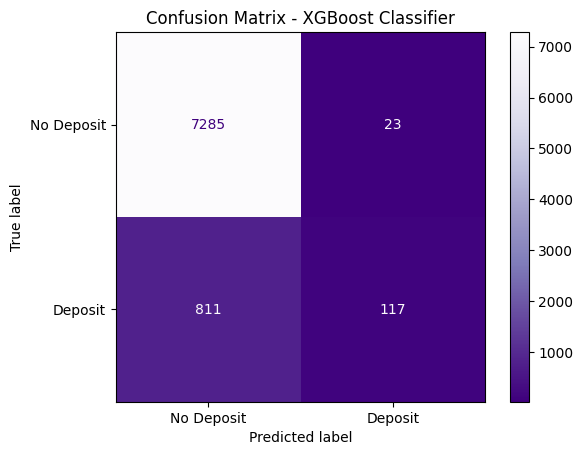

In [36]:
cm = confusion_matrix(y_test, y_pred_xgb)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=['No Deposit', 'Deposit'])

# Plot the confusion matrix
disp.plot(cmap=plt.cm.Purples_r)
plt.title("Confusion Matrix - XGBoost Classifier")
plt.show()

From the confusion matrix, based on our business purpose where we want to have efficient marketing campaign, means high True Positive among all Positive Predicted Label, we got 117 of 140, indicates our model can predict 84% of predictions. 

### **6.4.2. Learning Curve**  
A learning curve evaluates how well a machine learning model performs as it learns from more data or is trained longer.

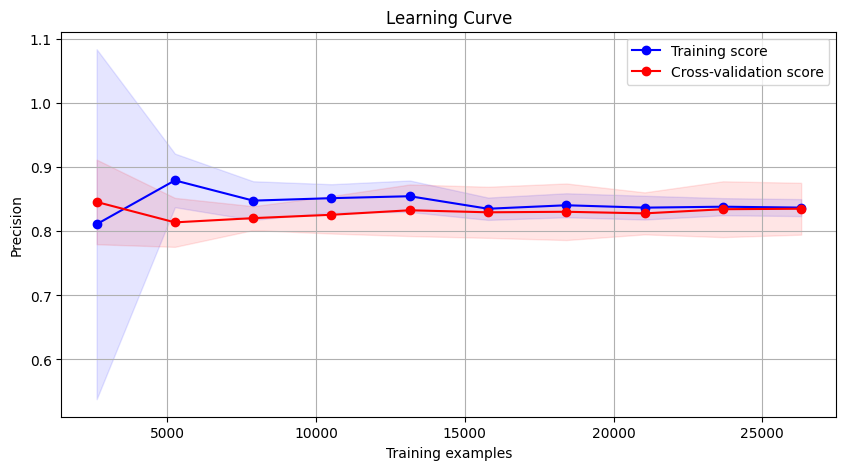

In [37]:
# Create learning curve
train_sizes, train_scores, test_scores = \
    learning_curve(xgb_model, X_train, y_train, cv=ShuffleSplit(n_splits=10, test_size=0.2, random_state=42),
                   train_sizes=np.linspace(0.1, 1.0, 10), scoring='precision', n_jobs=-1)

# Calculate mean and standard deviation of training and test scores
train_scores_mean = np.mean(train_scores, axis=1)
train_scores_std = np.std(train_scores, axis=1)
test_scores_mean = np.mean(test_scores, axis=1)
test_scores_std = np.std(test_scores, axis=1)

# Plot learning curve
plt.figure(figsize=(10, 5))
plt.fill_between(train_sizes, train_scores_mean - train_scores_std,
                 train_scores_mean + train_scores_std, alpha=0.1, color="b")
plt.fill_between(train_sizes, test_scores_mean - test_scores_std,
                 test_scores_mean + test_scores_std, alpha=0.1, color="r")
plt.plot(train_sizes, train_scores_mean, 'o-', color="b", label="Training score")
plt.plot(train_sizes, test_scores_mean, 'o-', color="r", label="Cross-validation score")
plt.xlabel("Training examples")
plt.ylabel("Precision")
plt.title("Learning Curve")
plt.legend(loc="best")
plt.grid(True)
plt.show()

In [38]:
pd.DataFrame({'TrainingScoreMean':train_scores_mean,
              'TrainingScoreSD':train_scores_std,
              'TestScoreMean': test_scores_mean,
              'TestScoreSD':test_scores_std}).round(2)

,TrainingScoreMean,TrainingScoreSD,TestScoreMean,TestScoreSD
0,0.81,0.27,0.85,0.07
1,0.88,0.04,0.81,0.04
2,0.85,0.03,0.82,0.02
3,0.85,0.02,0.83,0.03
4,0.85,0.02,0.83,0.04
5,0.84,0.02,0.83,0.04
6,0.84,0.02,0.83,0.04
7,0.84,0.02,0.83,0.03
8,0.84,0.01,0.83,0.04
9,0.84,0.01,0.84,0.04


From the learning curve, the model shows stable and similar precision on both training and validation data as the dataset size increases, suggesting that the model is well-generalized and not overfitting.

### **6.4.3. Reliability Curve**  
A calibration curve in the context of machine learning and classification tasks is a graphical tool used to assess how well probabilistic predictions from a classification model align with the actual outcomes or frequencies of those predictions. It helps to evaluate whether the predicted probabilities reflect the true likelihood of a positive outcome (in this case:deposit being subscribed).

For example, if our model predicts a probability of 0.8 for a certain event, we would expect that event to occur approximately 80% of the time when the model makes such predictions. The calibration curve visually compares these predicted probabilities against the actual frequencies, providing insights into the reliability and accuracy of the model's probabilistic forecasts.

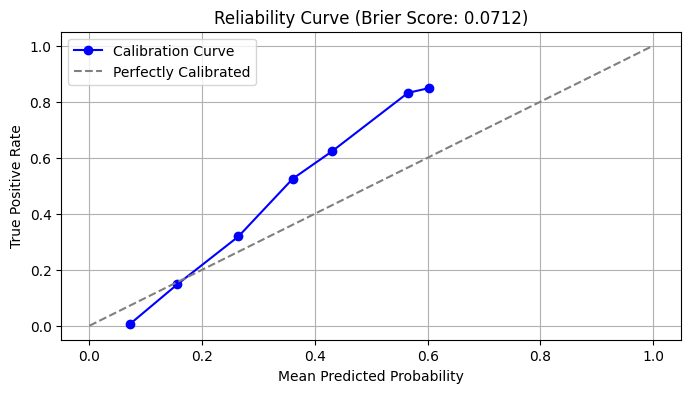

Brier Score: 0.0712147845452677


In [126]:
# Predict probabilities on the test set
probabilities = xgb_model.predict_proba(X_test)[:, 1]

# Compute calibration curve
true_prob, predicted_prob = calibration_curve(y_test, probabilities, n_bins=10)
# Calculate Brier score
brier = brier_score_loss(y_test, probabilities)

# Plot calibration curve
plt.figure(figsize=(8, 4))
plt.plot(predicted_prob, true_prob, marker='o', linestyle='-', color='blue', label='Calibration Curve')
plt.plot([0, 1], [0, 1], linestyle='--', color='gray', label='Perfectly Calibrated')
plt.xlabel('Mean Predicted Probability')
plt.ylabel('True Positive Rate')
plt.title('Reliability Curve (Brier Score: {:.4f})'.format(brier))
plt.legend()
plt.grid(True)
plt.show()

print('Brier Score:', brier)

The Brier score, named after Glenn Brier, is a metric used to evaluate the accuracy of probabilistic predictions made by a classification model. It measures the mean squared difference between predicted probabilities (of the positive class, for example) and the actual outcomes (binary labels).

A lower Brier score indicates better calibration and better prediction accuracy of probabilities, meaning the predicted probabilities are closer to the actual outcomes.
In our model, Brier score is approximately 0.07, which indicates how well-calibrated the predicted probabilities are. This may be due to the preprocessing steps being done correctly for the train and test data.

### **6.4.4. Business Simulation**  


**1. Scenario without Modeling**

In this scenario our bank will give campaign to all customers, that is 8,236 unseen data with conversion rate 11.27%. Here is the cost revenue calculation :

Total deposit subscription = 928 customers  
Conversion Rate = 11.27%
<br>Total telemarketing cost = 8,236 x EUR 23 = EUR 189,428
<br>ROMI (Return on Marketing Investment) = 144.92 %

**2. Scenario with Modeling**

After we do modeling, we can calculate the possible revenue and ROMI from 8.236 unseen data based on the confusion matrix.

TP (Predict Deposit, Actual Deposit) : 117
<br>FP (Predict Deposit, Actual No Deposit) : 23
<br>FN (Predict No Deposit, Actual Deposit) : 811
<br>TN (Predict No Deposit, Actual No Deposit) :  7,285

We will give campaign only to customers who are predicted to Deposit (TP and FP) :

Total deposit subscription = 117 of 140 customers   
Conversion Rate = 117/(117+23) * 100 = 83.57 %
<br>Total revenue =  117 x EUR 500 = EUR 58,500
<br>Total telemarketing cost = (117 + 23) x EUR 23 = EUR 3,220
<br>ROMI (Return on Marketing Investment) = (58,500 - 3,220)/3,220 = 1,716.7%

**3. Comparison:**

* **Without modeling:**  
  CVR  : 11.27%  
  ROMI : 144.92%.

* **With modeling**:  
  CVR  : 83.57 %  
  ROMI : 1,716.7%

* **Impact of modeling:**  
  **1. Conversion Rate improved by 7.4 times**.

  **2. Return in Marketing Investment (ROMI) improved by 11,84 times**.

<h1><b>7. Best Model Explanation

<h2><b>7.1. How Final Model Works

XGBoost is a machine learning algorithm that belongs to the class of ensemble methods, specifically gradient boosting machines (GBMs). 
XGBoost is based on the gradient boosting framework, which sequentially builds models to correct the errors made by previous models. It combines the predictions of multiple weak learners (typically decision trees) to create a strong predictive model, but incorporates several advanced features to improve performance and efficiency.

 The process involves:

**1. Initialization**  
        The model starts with an initial prediction, which is often the mean of the base class probabilities for classification. Start with an initial prediction.  

**2. Training the First Base Learner**   
        XGBoost starts by training a simple base learner, such as a decision tree with a single split. This learner attempts to fit the initial residuals (errors between actual and predicted values) serves as the starting point for the model. 

**3. Compute Residuals**   
        The residuals are calculated as the difference between the actual target values and the current predictions of the model. These residuals indicate where the model is underperforming.   

**4. Build a Tree to Fit Residuals**    
        A new decision tree is built to predict these residuals. The goal of this tree is to reduce the residuals by fitting the data points where the previous model’s predictions were incorrect.   

**5. Gain Calculation After Split Finding**   
        XGBoost uses a sophisticated split-finding algorithm to identify the best splits for the decision tree, aiming to maximize the gain, which is the improvement in the loss function due to a particular split.   

**6. Update Predictions**   
        After training each tree, the predictions of the ensemble model are updated by adding the scaled predictions of the new tree. The learning rate α controls the contribution of each tree, helping to prevent overfitting by scaling down the updates.   

**7. Iteration**   
        Repeat steps 3 to 6for a predefined number of iterations or until the model’s performance stops improving.  

**8. Pruning and Regularization**  
        XGBoost includes regularization terms in the objective function to control the complexity of the trees and prevent overfitting. Pruning is applied to remove splits that do not improve the model’s performance significantly.  
    
**9. Final Output** 

<h2><b>7.2. Global Explanation

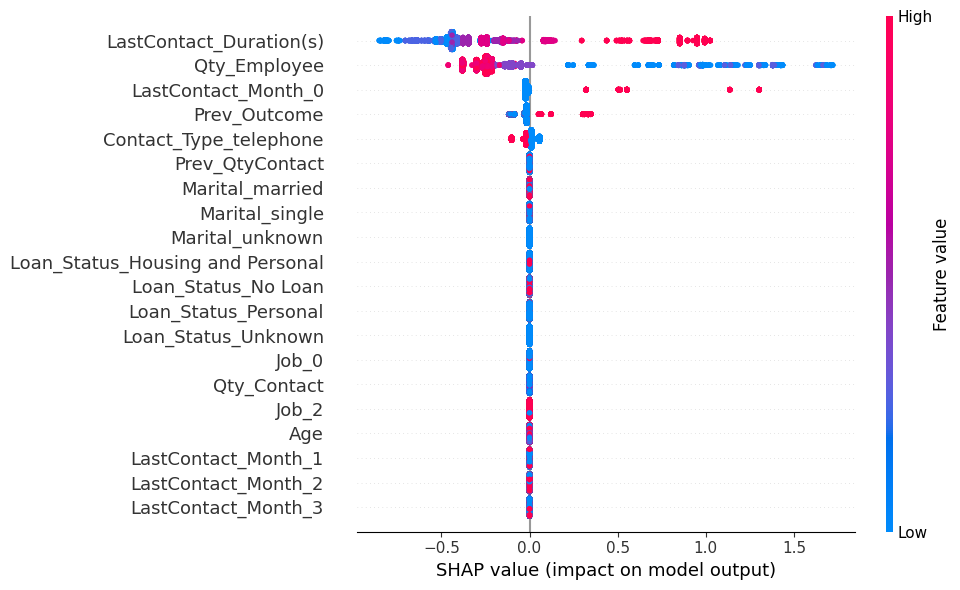

In [192]:
# Apply preprocessing to get the transformed feature names
X_train_tf = xgb_model[:-1].transform(X_train)
X_test_tf = xgb_model[:-1].transform(X_test)

# Feature name
unique_feature_names = xgb_model[0][1:].get_feature_names_out()

# create a SHAP TreeExplainer
explainer = shap.TreeExplainer(xgb_model.named_steps['Modeling'])

# calculate SHAP values for the test set
shap_values = explainer.shap_values(X_test_tf)

# visualize global feature importance
shap.summary_plot(shap_values, X_test_tf,
                  feature_names=unique_feature_names,
                  title="SHAP Summary Plot",
                  plot_size=(10, 6))

This SHAP (SHapley Additive exPlanations) summary plot shows the impact of each feature on the model's output for the the marketing campaign.  
Most Influential Features:

* **LastContact_Duration(s)**  
Has the most significant impact on the model's predictions. Higher values (red) generally increase the likelihood of a positive prediction, as indicated by the SHAP value distribution. ***The longer the duration of the call, the more likely it is that the client will agree to the deposit.***

* **Qty_Employee**  
Also has a notable impact. Indicate that higher numbers of employees are associated with a lower likelihood of a client subscribing to a deposit. This suggests that when the Qty_Employee feature has high values, it tends to reduce the probability of a deposit subscription. This might imply that in contexts with many employees, the economic environment could be more stable, and clients might not feel as much need to invest in a term deposit. In conclusion, ***the fewer the number of employees, the more they tend to make deposits***.

* **LastContact_Month_0**  
This feature's impact shows that **contacts made in a specific month (March or Deccember, referred to binary encoded) can have a varied effect on the likelihood of a deposit**. The impact can be either positive or negative, depending on other interacting factors.

* **Contact Type Telephone**  
Indicate that **when the contact type is telephone, it generally increases the likelihood of a subscription**. The blue line shows that other forms of contact might be less effective in securing deposits.

* **Previous Outcome Success**  
Significantly increase the likelihood of a deposit. **If a previous campaign was successful, the client is more likely to subscribe again.**  

Other features seem has no impact.  

<h2><b>7.3. Local Explanation: Counterfactual

A counterfactual explanation in machine learning provides insight into how changes to the input features of a particular instance could lead to a different prediction by a model. It answers the question: "What minimal changes to the input data would have resulted in a different outcome?"

In [128]:
train_df = X_train.copy()

# Specify Numerical Columns
cont_features = list(train_df.select_dtypes('number').columns)

train_df['Deposit'] = y_train.reset_index(drop=True)

# Define the Data Interface
data_interface = dice_ml.Data(dataframe=train_df, continuous_features=cont_features, outcome_name='Deposit')

# Define the Model Interface
model_interface = dice_ml.Model(model=xgb_model, backend='sklearn')

# Initialize Dice
dice = Dice(data_interface, model_interface)

In [148]:
# Generate Counterfactuals
cf = dice.generate_counterfactuals(X_test.reset_index(drop=True).loc[[7123]], desired_class='opposite', total_CFs=3,
                                   features_to_vary='all')

# Display
cf.visualize_as_dataframe(show_only_changes=True)

# Store Generated Counterfactual Instance
counterfact = cf.cf_examples_list[0].final_cfs_df

100%|██████████| 1/1 [00:03<00:00,  3.48s/it]

Query instance (original outcome : 0)


,age,job,marital,education,default,housing,loan,contact,month,day_of_week,duration,campaign,pdays,previous,poutcome,emp.var.rate,cons.price.idx,cons.conf.idx,euribor3m,nr.employed,Deposit
0,30,admin.,single,high.school,no,yes,no,cellular,aug,fri,90,1,999,0,nonexistent,1.4,93.444,-36.099998,4.964,5228.100098,0



Diverse Counterfactual set (new outcome: 1)


,age,job,marital,education,default,housing,loan,contact,month,day_of_week,duration,campaign,pdays,previous,poutcome,emp.var.rate,cons.price.idx,cons.conf.idx,euribor3m,nr.employed,Deposit
0,-,-,-,unknown,-,-,-,-,-,mon,1897,17,-,-,success,-,-,-,-,-,1
1,-,-,-,-,yes,no,-,-,-,-,1443,-,-,-,success,-,-,-47.2,-,-,1
2,-,-,unknown,-,-,-,-,-,may,-,2390,-,-,-,success,-,-,-,-,-,1


From counterfactual results show possible changes to features that could lead to a different prediction outcome for the given instance. In this case, our original instance with features such as age 30, job as an admin, marital status as single, and call duration 90 secs had an outcome of 0, which likely corresponds to "No" for a target such as "subscription of a term deposit."

The counterfactual set suggests changes that could lead to an outcome of 1 (possibly "Yes"). These changes include:  
Change Marital to "unknown", Education to "unknown", and so on. But, we know that we couldn't change these data. Therefore, all we can do is change the call duration or when we call the customers. From all possible suggestions, **we recommend the marketing team to call the customer in May around 40 mins via cellular**. 

Now, let's take a look at some examples.


In [149]:
# Generate Counterfactuals
cf = dice.generate_counterfactuals(X_test.reset_index(drop=True).loc[[532]], desired_class='opposite', total_CFs=3,
                                   features_to_vary='all')

# Display
cf.visualize_as_dataframe(show_only_changes=True)

# Store Generated Counterfactual Instance
counterfact = cf.cf_examples_list[0].final_cfs_df

100%|██████████| 1/1 [00:06<00:00,  6.45s/it]

Query instance (original outcome : 0)


,age,job,marital,education,default,housing,loan,contact,month,day_of_week,duration,campaign,pdays,previous,poutcome,emp.var.rate,cons.price.idx,cons.conf.idx,euribor3m,nr.employed,Deposit
0,36,services,married,high.school,unknown,no,no,telephone,jun,wed,90,3,999,0,nonexistent,1.4,94.464996,-41.799999,4.962,5228.100098,0



Diverse Counterfactual set (new outcome: 1)


,age,job,marital,education,default,housing,loan,contact,month,day_of_week,duration,campaign,pdays,previous,poutcome,emp.var.rate,cons.price.idx,cons.conf.idx,euribor3m,nr.employed,Deposit
0,-,management,-,-,-,-,-,-,-,-,1574,14,-,-,success,-,-,-,-,-,1
1,-,-,-,-,-,-,-,cellular,-,-,1872,-,-,-,success,-,-,-,2.414,-,1
2,-,-,-,-,-,-,-,-,-,-,3771,-,655,-,success,-,-,-,-,-,1


For 36-year old-married customers who worked in the services field and were contacted via telephone for 90 seconds, **we recommend calling the customers via cellular for around 31 minutes.**

In [180]:
# Generate Counterfactuals
cf = dice.generate_counterfactuals(X_test.reset_index(drop=True).loc[[765]], desired_class='opposite', total_CFs=3,
                                   features_to_vary='all')

# Display
cf.visualize_as_dataframe(show_only_changes=True)

# Store Generated Counterfactual Instance
counterfact = cf.cf_examples_list[0].final_cfs_df

100%|██████████| 1/1 [00:01<00:00,  1.15s/it]

Query instance (original outcome : 0)


,age,job,marital,education,default,housing,loan,contact,month,day_of_week,duration,campaign,pdays,previous,poutcome,emp.var.rate,cons.price.idx,cons.conf.idx,euribor3m,nr.employed,Deposit
0,54,management,married,university.degree,unknown,no,yes,telephone,jun,mon,140,4,999,0,nonexistent,1.4,94.464996,-41.799999,4.865,5228.100098,0



Diverse Counterfactual set (new outcome: 1)


,age,job,marital,education,default,housing,loan,contact,month,day_of_week,duration,campaign,pdays,previous,poutcome,emp.var.rate,cons.price.idx,cons.conf.idx,euribor3m,nr.employed,Deposit
0,-,-,-,professional.course,yes,-,-,-,-,-,719,10,-,6,success,-,-,-,-,-,1
1,-,-,single,-,-,-,-,-,-,thu,1471,-,-,-,success,-,-,-45.0,-,-,1
2,47,-,-,professional.course,-,-,-,cellular,jul,-,3870,-,-,-,success,-,-,-,1.371,-,1


Another example comes from 54-year old-married customers who worked in management with specific credit and loan and were contacted in july via telephone 140 secs, **we recommend calling the customers via cellular in july for around 1 hour**. Long phone calls may stimulate the customer's interest level, requiring a deeper explanation.

In [186]:
# Generate Counterfactuals
cf = dice.generate_counterfactuals(X_test.reset_index(drop=True).loc[[598]], desired_class='opposite', total_CFs=3,
                                   features_to_vary='all')

# Display
cf.visualize_as_dataframe(show_only_changes=True)

# Store Generated Counterfactual Instance
counterfact = cf.cf_examples_list[0].final_cfs_df

  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00,  1.03it/s]

Query instance (original outcome : 0)


,age,job,marital,education,default,housing,loan,contact,month,day_of_week,duration,campaign,pdays,previous,poutcome,emp.var.rate,cons.price.idx,cons.conf.idx,euribor3m,nr.employed,Deposit
0,31,technician,divorced,high.school,no,no,no,cellular,aug,fri,101,4,999,0,nonexistent,1.4,93.444,-36.099998,4.964,5228.100098,0



Diverse Counterfactual set (new outcome: 1)


,age,job,marital,education,default,housing,loan,contact,month,day_of_week,duration,campaign,pdays,previous,poutcome,emp.var.rate,cons.price.idx,cons.conf.idx,euribor3m,nr.employed,Deposit
0,19,-,single,-,-,-,-,-,mar,-,3358,-,-,-,success,-,-,-42.0,-,-,1
1,76,-,-,-,-,-,-,-,dec,-,718,-,875,-,success,-,-,-,-,-,1
2,19,-,-,-,-,-,-,-,mar,-,3358,-,-,-,success,-,-,-42.0,-,-,1


For 31-year old-divorced customer who worked as a techniccian who were contacted in August for 101 secs. **We recommend calling this type of customers via cellular in Dec for 12 minutes or in March for around 56 minutes.**

In [191]:
# Generate Counterfactuals
cf = dice.generate_counterfactuals(X_test.reset_index(drop=True).loc[[75]], desired_class='opposite', total_CFs=3,
                                   features_to_vary='all')

# Display
cf.visualize_as_dataframe(show_only_changes=True)

# Store Generated Counterfactual Instance
counterfact = cf.cf_examples_list[0].final_cfs_df

100%|██████████| 1/1 [00:01<00:00,  1.42s/it]

Query instance (original outcome : 0)


,age,job,marital,education,default,housing,loan,contact,month,day_of_week,duration,campaign,pdays,previous,poutcome,emp.var.rate,cons.price.idx,cons.conf.idx,euribor3m,nr.employed,Deposit
0,36,blue-collar,married,basic.9y,unknown,yes,no,cellular,jul,thu,53,2,999,0,nonexistent,1.4,93.917999,-42.700001,4.958,5228.100098,0



Diverse Counterfactual set (new outcome: 1)


,age,job,marital,education,default,housing,loan,contact,month,day_of_week,duration,campaign,pdays,previous,poutcome,emp.var.rate,cons.price.idx,cons.conf.idx,euribor3m,nr.employed,Deposit
0,-,-,-,-,-,-,-,-,-,fri,4171,-,-,-,success,-,-,-,-,-,1
1,71,-,divorced,-,-,-,-,-,-,-,1526,-,-,-,success,-,-,-,-,-,1
2,-,-,-,-,-,-,-,-,-,fri,4171,-,-,-,success,-,-,-,1.828,-,1


Now we have 36-year old-married customers who worked as blue-collar contacted via cellular on Thursday, July for less than 1 minute. **We recommend calling the customers on Friday, July for more than 1 hour via cellular**.

There are some examples of counterfactual results where this is deep explanation for particular sample for global explanation where duration call, contact type, and month are importance features that can be changed from our side since other features can't be changed. **However, it is important to remember that this does not rule out the possibility of intervention from other variables.**

<h2><b>7.4. Model Trustworthiness

This section attempts to evaluate when the model works best and when it doesn't. Knowing when and how the model performs well can guide us to better decision-making. These are some samples to know what data for model to be trusted or reliable.

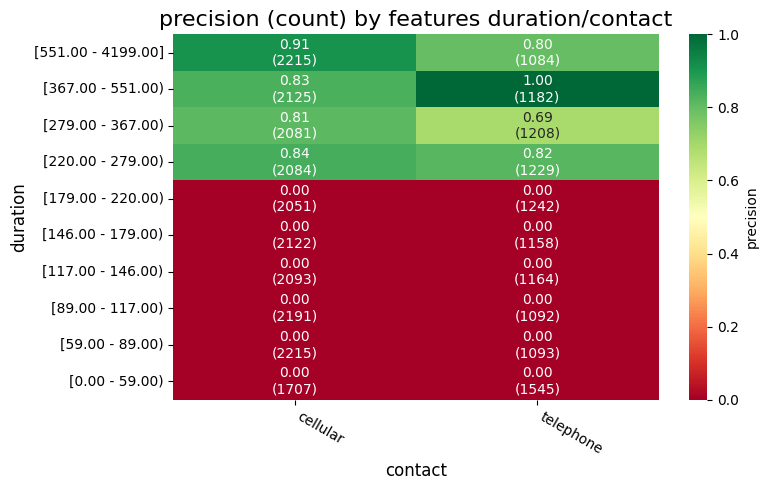

In [134]:
model_limit_duration_contact = SegmentPerformanceTest(
    feature_1='duration', feature_2='contact',
    alternative_scorer='precision')


model_limit_duration_contact.run(model=xgb_model, dataset=df_seen, target_label='Deposit')

If we look at the contact type and call duration, the model is credible based on the call duration of 220 seconds for both mobile and phone.

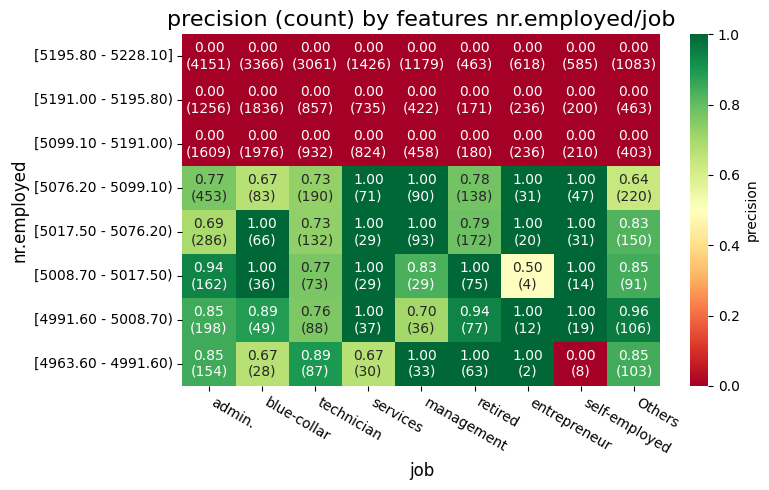

In [135]:
model_limit_job_employee = SegmentPerformanceTest(
    feature_1='nr.employed', feature_2='job',
    alternative_scorer='precision')

model_limit_job_employee.run(model=xgb_model, dataset=df_seen, target_label='Deposit')

For this heatmap, the model is trusted for number of employee less than equal to 5099 for all jobs except self-employed for 4963-4991 size of employee, but hit 1 precision for the rest of sizes. 

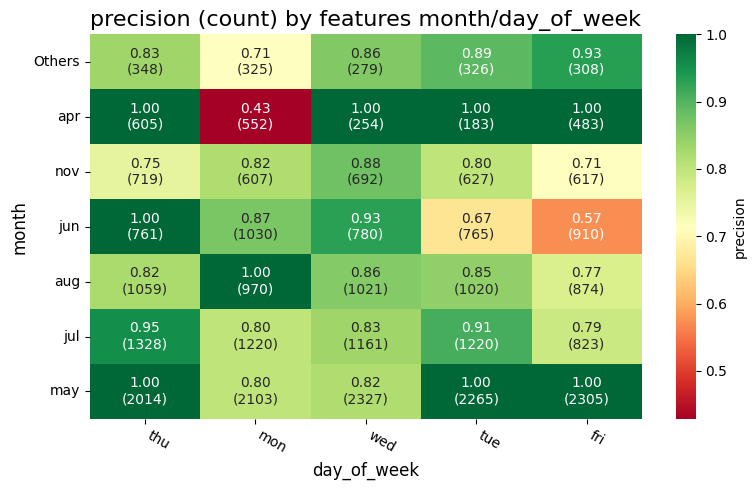

In [136]:
model_limit_lastmonth_andday = SegmentPerformanceTest(
    feature_1='month', feature_2='day_of_week',
    alternative_scorer='precision')

model_limit_lastmonth_andday.run(model=xgb_model, dataset=df_seen, target_label='Deposit')

Based on month and day, it seems model can be trusted in every working days except monday in April and May is the best month.

<h2><b>7.5. Model Saving

In [187]:
# Save the model
with open('xgboost-model.pkl', 'wb') as file:
    pickle.dump(xgb_model, file)

# **8. Conclusions and Recommendations**

<h2><b>8.1. Conclusions  

We developed the best model using data cleaning, feature extraction, preprocessing techniques, and model benchmarking which is the XGBoost Classifier. The model achieves a high accuracy of 90% and a precision of 84%, meaning it is effective at correctly predicting deposits, and from the model evaluation using the Learning Curve and Brier Score, the model shows the best performance and is expected to give accurate predictions. In summary, **the model can help Electric Bank improve its Conversion Rate 7.4 times and Return On Marketing Investment (ROMI) 11.84 times from original state by effective targeted telemarketing.**  

<h2><b>8.2. Model Limitation

In [138]:
display(X_train.describe(),
        X_train.describe(include='object'))

,age,duration,campaign,pdays,previous,emp.var.rate,cons.price.idx,cons.conf.idx,euribor3m,nr.employed
count,32881.000000,32881.000000,32881.000000,32881.000000,32881.000000,32881.000000,32881.000000,32881.000000,32881.000000,32881.000000
mean,39.942064,257.659226,2.563000,963.005748,0.172805,0.084152,93.576379,-40.513023,3.622719,5167.138265
std,10.276527,257.531174,2.771662,185.592075,0.496647,1.569707,0.578874,4.619861,1.733910,72.224863
min,18.000000,0.000000,1.000000,0.000000,0.000000,-3.400000,92.201000,-50.800000,0.634000,4963.600000
25%,32.000000,102.000000,1.000000,999.000000,0.000000,-1.800000,93.075000,-42.700000,1.344000,5099.100000
50%,38.000000,179.000000,2.000000,999.000000,0.000000,1.100000,93.749000,-41.800000,4.857000,5191.000000
75%,47.000000,319.000000,3.000000,999.000000,0.000000,1.400000,93.994000,-36.400000,4.961000,5228.100000
max,83.000000,4199.000000,56.000000,999.000000,7.000000,1.400000,94.767000,-26.900000,5.045000,5228.100000


,job,marital,education,default,housing,loan,contact,month,day_of_week,poutcome
count,32881,32881,32881,32881,32881,32881,32881,32881,32881,32881
unique,12,4,8,3,3,3,2,10,5,3
top,admin.,married,university.degree,no,yes,no,cellular,may,thu,nonexistent
freq,8269,19891,9718,26038,17241,27110,20884,11014,6834,28397


**Model Limitation**

1. This model is limited to historical data to serve its best performance.  
2. This final model have limitations based on the data and features used for modeling. It can predict subscribe to term deposit within the following ranges observed in the training data:
    - Age between 18-83 years old.
    - Last contact duration between 0 - 4199 seconds.
    - Number of contact during this campaign between 1 - 56 contacts.
    - Number of contact performed before this campaign between 0 - 7 contacts.
    - Number of employees between 4963 - 5228.

3. The model's predictions might be less reliable for clients with features outside the observed ranges.
4. The model only considers the features provided. Other factors not included in the model can also significantly impact subscribe term deposit decisions.

<h2><b>8.3. Recommendations

### **8.3.1. Business Insights**

As stated in the problem statement, Electric Bank aims to focus its telemarketing efforts on high-potential clients. Based on our model, **we recommend telemarketing efforts towards clients who predicted to subscribe.**

Additionally, our analysis show that demographic data does not significantly impact to subscribe decision. Instead, the number of employees is more influential. A higher number of employees is negatively associated with the probability of subscribing to a deposit product.

Furthermore, clients contacted via cellphone with longer last contact duration are more likely to subscibe to a term deposit. However, it's important to balance contact time; excessively long conversations may not be effective.

### **8.3.2. Recommendation for Marketing Team**

  1. **Alternative Model**   
      Since our model is limited to historical data, we took the initiative to create an alternative model where this model can be used to predict new fresh customers who have never been contacted at all. **This model** also provides good performance with a Recall score of 0.84 (focusing on True actual comes) and **increases CVR by 6.61 times and reduces telemarketing costs by 7.82 times**.  

  2. **Targeted Campaign**  
      - Use the predictive model to identify **customers who are most likely to subscribe** to a term deposit and design targeted marketing campaigns to engage these potential customers.  
      - In section 7.2 (Global Explanation: Shap), we found that the longer the duration of the call, the more likely it is that the client will agree to the deposit. We also found spesific month and contact type have significant impact. This global explanation was also supported by the findings in predictive modelling in section 7.3 (Local explanation: Counterfactual) where the desired outcomes are highly influenced by those features. 

  3. **Spesific Recommendation Samples**  
      Based on section 7.3 (Local explanation: Counterfactual), we found some examples how we can change the non-deposit customers to subscribe the deposit.  
      - 30-year old single customers who worked as an admin with housing loan via cellular for 40 mins in May  
      - 36-year old married customers who worked in services with no loan and credit via cellular for around 31 minutes.  
      - 54-year old married customers who worked in management with personal loan via celullar in July for around 1 hour.    
      - 31-year old divorced customers who worked as a technician via cellular in Dec for 12 minutes or in March for around 56 minutes.  
      - 36-year old married customers who worked as blue-collar via cellular on Friday, July for more than 1 hour.

  4. **Customer Database**  
      To ensure the accuracy and relevance of predictive models, it's crucial to maintain a robust customer database and collect high-quality data. This involves several key practices based on our EDA findings:  
      - **Maintain Data Integrity**: Establish a reliable system to store and manage customer data. Regularly update the database to prevent data from becoming outdated, and continuously monitor for data drift—a situation where changes in data patterns over time can reduce the accuracy of our model.  
      - **Ensure Complete and Accurate Data Collection**: Encourage customers to provide complete information, avoiding placeholders like 'Unknown.' Collect comprehensive economic details, such as income, which are vital for accurate analysis and modeling.   
      - **Capture Important Behavioral Data**: Include additional relevant data points, such as call timestamps, to understand customer behavior over time. This temporal information can improve the model’s predictive power by highlighting trends and patterns.  

  5. **Campaign Regulation**  
      Define a guidelines based on the model's insights to improve the probability of customers subscriptions. Use these regulations to refine campaign strategies and improve conversion rates. The recommendations are **what's the maximum call should we perform for a customer(in this case 56 max calls - based on our EDA findings), how many days should we call for a month, etc**.

<h3><b>8.3.3. Model Improvement Recommendations

1. Since our data looks like too complex, we recommend to do complex data preprocessing like feature creation or extraction and other advance techniques, such as Polynomial Features, PCA for socio-economic features, etc. This is to ensure we can capture more complex pattern for better model performance.     
2. From the section 6.4.2 (Model evaluation: Learning Curve), the model is stable even when the data training samples 10k, we recommend to use more data test and less data training to know how reliable this model for better result.  


<h3><b>8.3.4. When and How the Model Will be Used

* **Pre-start of New Campaign**
  Execute the model before launching a new campaign to generate a list of targeted clients who are most likely to subscribe. This will assist the marketing team in optimizing resource allocation effectively.

* **Trial of Actionable Steps Recommendations**  
  We've created an actionable steps based on our model performance and feature importance that has high contribution to model performance. For the first trial, marketing team can try to do telemarketing in spesific condition.  

* **Implementation**  
  Our model is designed for batch processing and bulk predictions, enabling efficient execution of marketing campaigns. After deployment, we implement continuous monitoring to ensure model performance remains optimal and responsive to any data shifts.

* **Monitoring Mechanism**

  - Regular Batch Updates: We update the model at scheduled intervals to incorporate new data, ensuring the model adapts to changing customer behaviors.  
  - Performance Tracking: Key metrics such as precision, conversion rates, and ROMI are tracked continuously to detect any performance degradation.  
  - Data Drift Detection: We use statistical techniques to monitor for data drift, ensuring that the model's predictions remain aligned with current trends.  
  - Automated Alerts: If the model's performance drops below a certain threshold, automated alerts are triggered to prompt immediate review and action.  


---
---